# Violence Recognition
    I have manually downloaded violence videos from youtube and split in to small size and scaled all of their resolution to 240 x 320. 
    I have used "moviepy" to do all these video processing and then saved them in to violence and nonviolence folders and kept in Res_videos folder.
    I have used the load_files() function in scikit-learn to get the absolute paths of these videos and their respective class labels. These paths will be later used to read the videos in to the sequence of images.


In [12]:
import os
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

In [13]:
raw_data = load_files(os.getcwd() + r'/Res_videos', shuffle=False)

In [14]:
files = raw_data['filenames']
targets = raw_data['target']

    Each video file is associated with its class label (0 - nonviolence, 1 - violence)

In [50]:
for pair in zip(train_files[:5], train_targets[:5]):
    print(pair)

('/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-device/code/users/smamidala318/Res_videos/violence/VMS_26.mp4', 1)
('/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-device/code/users/smamidala318/Res_videos/violence/videoplayback_4_27.mp4', 1)
('/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-device/code/users/smamidala318/Res_videos/nonviolence/videoplayback_2_178.mp4', 0)
('/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-device/code/users/smamidala318/Res_videos/violence/videoplayback_3_257.mp4', 1)
('/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-device/code/users/smamidala318/Res_videos/violence/videoplayback_3_177.mp4', 1)


    The whole data is randomly split into training and test data, with test data being one-fourth of the total data.

In [45]:
train_files, test_files, train_targets, test_targets = train_test_split(files, targets, test_size=1/4, random_state=191)

In [48]:
valid_files = train_files[400:]
valid_targets = train_targets[400:]

# Remaining data will be used for training the model
train_files = train_files[:400]
train_targets = train_targets[:400]

In [49]:
print('Total number of videos:', len(files))
print('\nNumber of videos in training data:', train_files.shape[0])
print('Number of videos in validation data:', valid_files.shape[0])
print('Number of videos in test data:', test_files.shape[0])

Total number of videos: 711

Number of videos in training data: 400
Number of videos in validation data: 100
Number of videos in test data: 178


#  Pre-processing the Data

## Videos_to_frames
    Taking the absolute video paths and returns the sequence of images


In [19]:
import os
import cv2
import numpy as np
from skvideo.utils import rgb2gray
from PIL import Image
from imutils.video import count_frames

def videos_to_frames(video_paths):
    # Height, Width, C = 240, 360, 3
    DataSet = np.array([])
    
    for j in range(len(video_paths)):
        _video_path = video_paths[j]
        frame_count = count_frames(_video_path, override=False)
        skip_frames = int(frame_count/4)
        data = np.array([])
        videoCapture = cv2.VideoCapture(_video_path)
        videoCapture.set(cv2.CAP_PROP_POS_MSEC,1)
        flag, frame = videoCapture.read()
        Height, Width, C = frame.shape
        count, C = 0, 3
        for i in range(frame_count-1):
            flag, frame = videoCapture.read()
            if flag:
              image = frame.copy()
            else:
              print('failed !!!',count)
            if flag:
                if count == 0:
                    data1 = image.reshape(1,Height,Width,C)
                else:
                  if count % skip_frames == 0:
                    data1 = np.concatenate((data1, image.reshape(1,Height,Width,C)))
            else:
                image = np.zeros((1,Height,Width,C))
                data1 = np.concatenate((data1,image))
            count += 1
            if len(data1) == 4:
              break
        
        data = np.array(data1)
        if j == 0:
            DataSet = data.reshape(1,data.shape[0], data.shape[1], data.shape[2],data.shape[3])
        else:
            DataSet = np.concatenate((DataSet, data.reshape(1, data.shape[0], data.shape[1], data.shape[2],data.shape[3])))
    return DataSet


In [ ]:
!pip install imutils

# Normalization
    Normalizing the image pixel values in to the range (-1 to 1)
    Normalization will be usefull to get better results from the network

In [20]:
from keras.utils import to_categorical
X_train = videos_to_frames(train_files)
y_train = train_targets
X_train = ((X_train/255.0)-0.5)*2 #sc.fit_transform(X_train)
X_train = X_train.astype(np.float32)

WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


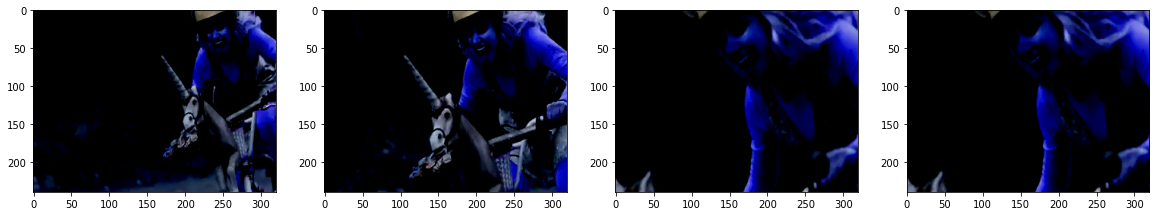

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

# After pre-processing

# Displaying the first frame of the first processed video from the training data

fig=plt.figure(figsize=(20,20))
columns = 4
rows = 1
for i in range(1, (columns*rows)+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[79][i-1])


In [23]:
X_valid = videos_to_frames(valid_files)
y_valid = valid_targets#to_categorical(valid_targets, num_classes=2)
X_valid = ((X_valid/255.0)-0.5)*2
X_valid = X_valid.astype(np.float32)

In [60]:
X_test = videos_to_frames(test_files)
y_test = test_targets#to_categorical(test_targets, num_classes=2)
X_test = ((X_test/255.0)-0.5)*2
X_test = X_test.astype(np.float32)

## Network Architecture
    Used Resnet50 to extract feature from the images.
    Each image in the sequence will be passed to the network and then all the features are concatenated.
    These features are then given to the ConvLSTM2D
    After ConvLSTM2D used Dense layers to finally get the target label.

In [26]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense, Dropout
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, BatchNormalization, Input, Lambda, LSTM, ConvLSTM2D, BatchNormalization, Reshape, Flatten

restnet = ResNet50(include_top=False, weights='imagenet', input_shape = X_train.shape[2:], pooling='avg')

output = restnet.layers[-2].output
print(output.shape,'before')
output = Reshape((1,8,10,2048), input_shape = (None, 8, 10, 2048))(output) #tf.keras.backend.expand_dims(output, axis = 1)
print(output.shape)
restnet = Model(restnet.input, output=output)
for layer in restnet.layers:
  layer.trainable = False

# model = Sequential()
branch_outputs = []
input = Input(shape = (X_train.shape[1:]))
for i in range(4):
  out = Lambda(lambda x: x[:, i])(input)
  out = restnet(out)
  branch_outputs.append(out)

out = keras.layers.Concatenate(axis = 1)(branch_outputs)
out = ConvLSTM2D(15, kernel_size=(3, 3), padding="same", return_sequences=True)(out)
out = BatchNormalization()(out)
out = ConvLSTM2D(10, kernel_size=(3, 3), padding="same", return_sequences=True)(out)
out = BatchNormalization()(out)
out = ConvLSTM2D(5, kernel_size=(3, 3), padding="same", return_sequences=False)(out)
out = BatchNormalization()(out)

out = Flatten()(out)
out = Dense(100, activation = 'relu')(out)
out = BatchNormalization()(out)
out = Dense(10, activation = 'relu')(out)
out = BatchNormalization()(out)
out = Dense(1, activation = 'sigmoid')(out)
model = Model(inputs=input, outputs=out)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
model.summary()
# Saving the model that performed the best on the validation set
# checkpoint = ModelCheckpoint(filepath='Model_3.weights.best.hdf5', save_best_only=True, verbose=1)

# # Training the model for 40 epochs
# history = model.fit(X_train, y_train, batch_size=4, epochs=30, 
#                     validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint])

(None, 8, 10, 2048) before
(None, 1, 8, 10, 2048)


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("re...)`
  from ipykernel import kernelapp as app


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 4, 240, 320,  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 240, 320, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 240, 320, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 240, 320, 3)  0           input_2[0][0]                    
____________________________________________________________________________________________

In [27]:
model.load_weights('Model_3.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=2, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 77.78%


Another function to take the frames from longer video to test. It will take one video and returns the frames. We have to specify how many frames should be skipped.
Here due to less resource availabily I have taken only 4 frames per second.

In [61]:
import os
import cv2
import numpy as np
from skvideo.utils import rgb2gray
from PIL import Image
from imutils.video import count_frames

def Tvideo_to_frames(video_path):
      skip_frames = 6
      data = np.array([])
      videoCapture = cv2.VideoCapture(video_path)
      videoCapture.set(cv2.CAP_PROP_POS_MSEC,1)
      flag, frame = videoCapture.read()
      Height, Width, C = frame.shape
      count, C = 0, 3
      print(video_path)
      frame_count = count_frames(video_path, override=False)
      for i in range(frame_count-1):
          flag, frame = videoCapture.read()
          if flag:
            image = frame.copy()
          else:
            print('failed !!!',count)
          # image = cv2.resize(image, (Height, Width), interpolation=cv2.INTER_LINEAR)
          if flag:
              if count == 0:
                  data1 = image.reshape(1,Height,Width,C)
              else:
                if count % skip_frames == 0:
                  # print(count)
                  data1 = np.concatenate((data1, image.reshape(1,Height,Width,C)))
          else:
              image = np.zeros((1,Height,Width,C))
              data1 = np.concatenate((data1,image))
          count += 1
      data = np.array(data1)
      return data

In [62]:
Test_video_path = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-device/code/users/smamidala318/test_videoout.mp4'
Test_video = Tvideo_to_frames(Test_video_path)
Test_video.shape
# X_Test = ((Test_video/255.0).astype(np.float32)-0.5)*2

/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-device/code/users/smamidala318/test_videoout.mp4


(892, 240, 320, 3)

In [63]:
vid_range = []
for i in range(222):
    print(i*4,i*4+4)
    test_data = Test_video[i*4:i*4+4]
    test_data = ((test_data/255.0)-0.5)*2
    test_data = test_data.astype(np.float32)
    prediction = model.predict(np.expand_dims(test_data,axis = 0))
    if prediction[0][0] > 0.7:
        print(prediction[0][0])
        pred = 1
        vid_range.append(i)
print(vid_range)

0 4
0.70000076
4 8
8 12
12 16
16 20
20 24
24 28
28 32
32 36
36 40
40 44
44 48
48 52
52 56
56 60
60 64
64 68
68 72
72 76
76 80
80 84
84 88
88 92
92 96
96 100
100 104
104 108
108 112
112 116
116 120
120 124
124 128
128 132
132 136
136 140
140 144
144 148
148 152
152 156
156 160
160 164
164 168
168 172
172 176
176 180
180 184
184 188
188 192
192 196
196 200
200 204
204 208
0.73238146
208 212
212 216
216 220
220 224
224 228
228 232
232 236
0.71793026
236 240
0.71942073
240 244
0.721259
244 248
0.7583079
248 252
0.8060023
252 256
0.7433877
256 260
260 264
0.7376361
264 268
268 272
272 276
276 280
280 284
284 288
288 292
292 296
296 300
300 304
0.77037233
304 308
0.763614
308 312
312 316
0.7354041
316 320
0.7220699
320 324
324 328
328 332
332 336
336 340
340 344
344 348
348 352
352 356
356 360
360 364
364 368
368 372
372 376
376 380
380 384
384 388
388 392
392 396
396 400
400 404
404 408
408 412
412 416
416 420
420 424
424 428
428 432
432 436
0.70769566
436 440
440 444
444 448
448 452
452 45

These are the seconds in the video 0, 51, 58, 59, 60, 61, 62, 63, 65, 75, 76, 78, 79, 108, 121, 162, 200